# Referenced ODMR Analysis

Author: Ryan Corbyn, 28th May 2021

This code makes use of many of the same methods as the CW ODMR dataset to analyse the datasets that are recorded with the microwave switch in place to allow for each ODMR frequency pixel point to be referenced to either a fixed ODMR frequnecy or to a empty channel with no microwaves applied. 

In [60]:
import scipy.optimize as opt 
import numpy as np 
import matplotlib.pyplot as plot 
import os 
import pandas as pd
import skimage.feature as si

We start the code by loading in the dataset, the parameters file and the plot parameters.  

In [7]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [8]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [9]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

Creates a numpy array with the microwave frequency scan range from the params file. 

In [10]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    
    return(freq)

Normalise the ODMR data to the Reference data. Then find the mean of the normalised data. 

In [11]:
def normalise_data(reference_data, odmr_data):
    # normalise the data to the maximum value of the mean dataset. 
    norm_odmr_data = odmr_data/reference_data
    return(norm_odmr_data)

In [48]:
def mean_data(odmr_data):
    # find the mean data 
    mean_odmr_data =  np.mean(odmr_data, axis = 2)
    return(mean_odmr_data)

In [32]:
def reshape_data(reference_data, odmr_data, params_values):
    '''Here we re-shape the reference and the ODMR datasets into a 3D array, 
    based on the number of line scans, frequnecy points and repeats per frequnecy 
    have been used to build the ODMR dataset.'''
    
    # Create variables with the frequnecy scan parameters. 
    num_of_line_scans = int(params_values[4])
    num_of_freqs =  int(1000*(params_values[1]-params_values[0])/params_values[2]) + 1
    points_per_freq = int(params_values[8])
    print(num_of_line_scans, num_of_freqs, points_per_freq)
    # Reshape the ODMR and reference datasets. 

    odmr_shape_3D = odmr_data[0:num_of_freqs*points_per_freq].reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    reference_data_3D = reference_data[0:num_of_freqs*points_per_freq].reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    
    return(odmr_shape_3D, reference_data_3D)

Generates a scatter plot of the mean noramlised ODMR data. 

In [33]:
def scatter_plot(freq, mean_data, dwell_time):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    
    ax2.set_xlim(np.min(freq),np.max(freq))
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Counts per ' + str(dwell_time) + r'$\mu$s', fontsize = 18)
    return(fig2, ax2)

In [34]:
def normalised_scatter_plot(freq, mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    
    ax2.set_xlim(np.min(freq),np.max(freq))
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Normalised Counts (A.U.)', fontsize = 18)
    return(fig2, ax2)

Find the initial parameters for the double lorentz fitting for the dataset, along with the code that is required for the lorentz fitting to be performed. 

In [35]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    
    half_data_length = int((len(freq)-1)/2) - 5 # This brings the mid-value to 2.87GHz 
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate dip_depth
    dip_depth = [odmr_data[low_freq_min_index[0][0]]  - flourescent_baseline, 
                 odmr_data[high_freq_min_index[0][0]+half_data_length]  - flourescent_baseline]
    
    #contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
    #            np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, dip_depth, flourescent_baseline)

In [36]:
def optimised_lorentz_fit(freq, mean_data, init_params, lower_bounds, upper_bounds):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, 
                                       sigma = y_error, bounds = (lower_bounds, upper_bounds))
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [37]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

Plot the fitting of the double lorentzian line shape and adds the labels and legends to the graphs. 

In [38]:
def plot_fitting(ax2, freq, dwell_time):
    # plot the y fit. 
    
    high_res_freq = np.linspace(freq[0], freq[len(freq)-1], 10*len(freq)+1)
    
    # create the double lorentz fit array
    y_fit_high_res = double_lorentz(high_res_freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    ax2.plot(high_res_freq, y_fit_high_res, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    
    return(ax2, y_fit)

In [39]:
def get_fitting_contrast(res_freq1, res_freq2, freq, y_fit, baseline, step):
    
    step = str(step/1000) # step size in GHz and string
    decimals = step[::-1].find('.') # find the number of decimal points in the steps. 
    
    first_freq_min_index = (np.abs(freq-round(res_freq1, decimals))).argmin()
    second_freq_min_index =(np.abs(freq-round(res_freq2, decimals))).argmin()

    contrast = [(baseline - y_fit[first_freq_min_index])/baseline, (baseline - y_fit[second_freq_min_index])/baseline]
    
    return(contrast)

Find the R squared value for the fitting verses the actual dataset. 

In [40]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

The method to save the data into a folder on the iDrive. 

In [41]:
def save_data(date, file_ID, fitted_contrast, coeffs, opt_error, r_squared, fig1):
    
    destination_folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\' + date + '\\' #+ 'power_sweep\\'
    output_data_file = destination_folder + date + '_reference_ODMR_analysis.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name'  + '\t' +
                     'Resonant frequency 1 (GHz)' + '\t' + 'Error Resonant frequency 1 (GHz)' + '\t' + 
                     'Resonant frequency 1 contrast (%)' + '\t' + 
                     'FWHM 1 (MHz)' + '\t' + 'FWHM 1 error (MHz)' + '\t' + 
                     'Resonant frequency 2 (GHz)' + '\t' + 'Error Resonant frequency 2 (GHz)' + '\t' + 
                     'Resonant frequency 2 contrast (%)' + '\t' + 
                     'FWHM 2 (MHz)' + '\t' + 'FWHM 2 error (MHz)' + '\t' + 
                     'Off Res Fluorescence intensity (per dwell time)' + '\t' + 
                     'R^2 for fitting' +'\n')
    # Writing contrast dip description to the .dat file
    
    with open(output_data_file, "a") as wf:
        wf.write(file_ID  + '\t' +
                 str(coeffs[1]) + " \t"  + str(opt_error[1]) + " \t" + 
                 str(fitted_contrast[0]*100) + " \t"  +  
                 str(abs(coeffs[2])*1000) + " \t" + str(opt_error[2]*1000) + " \t" + 
                 str(coeffs[4]) + " \t"  + str(opt_error[4]) + " \t" + 
                 str(fitted_contrast[1]*100) + " \t" +
                 str(abs(coeffs[5])*1000) + " \t" + str(opt_error[5]*1000) + " \t" + 
                 str(coeffs[6]) + " \t" +str(r_squared) + '\n')
        
    # Saving a plot of the raw data to a folder. 
    #fig1.savefig(destination_folder + file_ID + '_heatmap.pdf', transparent = True)    
    #fig1.savefig(destination_folder + file_ID + '_heatmap.png', transparent = True) 
    
    fig1.savefig(destination_folder + file_ID + '.pdf', transparent = True)    
    fig1.savefig(destination_folder + file_ID + '.png', transparent = True) 

### Code starts here 

Here we set the folder directory and the file names of the datasets. We then load the dataset into the numpy arrays and generates the frequnecy array for the scans performed and the dwell time of the pixels used.

In [63]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

date = '20210909' # Date on folder in which the experimental data is saved. 
set_plot_params()

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\2021\\' + date + '\\'
#folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\Imaging\\'

data_set = '_referenced_odmr_30_' # Short hand for the file name. 

# Set the file names for all 4 data sets recorded from the experiment. 
file_name_ODMR1 = date + data_set + 'ODMR1.dat'
file_name_ODMR2 = date + data_set + 'ODMR2.dat'
file_name_Ref1 = date + data_set  + 'Ref1.dat'
file_name_Ref2 = date + data_set  + 'Ref2.dat'

# Extract the ODMR and reference datasets from the data we are looking at. 
odmr_data = load_data(folder_path + file_name_ODMR1)
reference_data = load_data(folder_path + file_name_Ref1)

# Get the parameters for the experiment. 
params_file = load_params(folder_path + date  + data_set + 'Params.txt')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# Dwell time of the measurment 
dwell_time = params_values[3]

odmr_data, reference_data = reshape_data(reference_data, odmr_data, params_values)

1 131 100


Here we normalise the ODMR data to the reference data and then find the mean of this normalised data. The code then works to determine the fitting of the double lorentzian to the ODMR data and find the R squared value for the fitting to the data. 

Contrast = [0.06482558373922823, 0.06482558373922823]
r squared = 0.9129529004959597


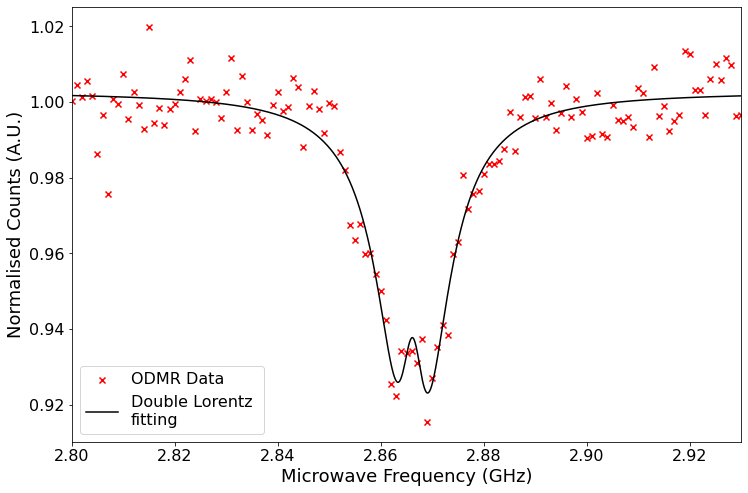

In [64]:
# Normalise the ODMR data against the reference data. 
normalised_ODMR = normalise_data(reference_data, odmr_data)

# Mean of the normalise dataset. 
mean_norm_odmr = mean_data(normalised_ODMR)
mean_norm_odmr = mean_norm_odmr[0,:]
#print(mean_norm_odmr.shape)

# Plot the mean normalised dataset as a scatter plot. 
fig1, ax1 = normalised_scatter_plot(freq, mean_norm_odmr)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, dip_depth, flourescent_baseline = get_init_params(mean_norm_odmr, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
init_params = [dip_depth[0], freq_mins[0], 0.005, dip_depth[1], freq_mins[1], 0.005, flourescent_baseline]

# Set the upper and lower bounds for the fitting algorithm. 
lower_bounds = [-np.inf, init_params[1] - 0.01, 0, -np.inf, init_params[4] - 0.01, 0, 0]
upper_bounds = [np.inf, init_params[1] + 0.01, 1, np.inf, init_params[4] + 0.01, 1, np.inf]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, mean_norm_odmr, init_params,
                                                    lower_bounds, upper_bounds)

# plot the fitting to ax2
ax1, y_fit = plot_fitting(ax1, freq, params_values[3])

fitted_contrast = get_fitting_contrast(fitting_params[1], fitting_params[4], freq, y_fit,  fitting_params[6], params_values[2])
print('Contrast = ' + str(fitted_contrast))

# get the r^2 value for the fitting 
r_squared = get_r_squared(freq, mean_norm_odmr, y_fit)
print('r squared = ' + str(r_squared))

In [65]:
# Save the data. 

#save_data(date, file_name_ODMR1, fitted_contrast, coeffs, opt_error, r_squared, fig1)

(131,)
(131,)


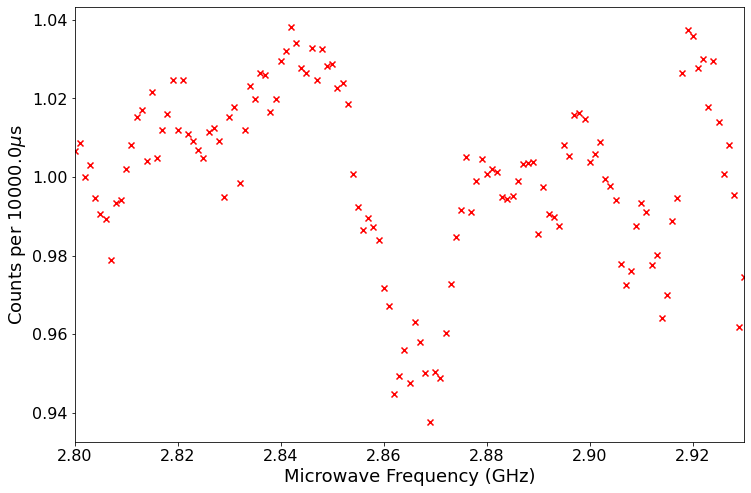

In [66]:
print(mean_norm_odmr.shape)
print(freq.shape)

mean_odmr_data = mean_data(odmr_data)

fig2, ax2 = scatter_plot(freq, mean_odmr_data/np.mean(mean_odmr_data), dwell_time)

In [52]:
print(odmr_data.shape)

(500, 151)


In [3]:
def get_data(file_location):
    
    # open file and save all data in an array. 
    with open(file_location, 'r') as array3D:
        content = array3D.read()
    
    # intialise variables. 
    image_data = []
    scan_metadata = []
    store_scan_metadata = []
    
    # ignore the first 6 lines of the array (plain text)
    lines = content.splitlines()[6:]
    for line in lines:
        # remove the "new line" text from the row. 
        row = line.split('\t')
        # Save metadata and PSF scan data in separate variables (done by length due to ease)
        # as strings
        if len(row) < 20:
            store_scan_metadata.append(row)
            continue 
        image_data.append(row[0:len(row)-1])
    
    # Extract the metadata for the scan used to create the data_set. 
    scan_metadata = np.array(store_scan_metadata[4]
                             [0:len(store_scan_metadata[4])-1]).astype(float)
    
    # Convert PSF scan data to float. 
    image_data = np.array(image_data).astype(float)
    
    return(image_data, scan_metadata)

In [4]:
def generate_3D_scan_range(scan_data):
    
    x_scan = np.linspace(0, scan_data[2]-scan_data[1], int(scan_data[3]))
    y_scan = np.linspace(0, scan_data[5]-scan_data[4], int(scan_data[6]))
    z_scan = np.linspace(0, scan_data[8]-scan_data[7], int(scan_data[9]))
    
    # In python, the 3D stack shape is (z, x, y)
    psf_array_shape = [int(scan_data[9]),  int(scan_data[3]),  int(scan_data[6])]
    
    return([x_scan, y_scan, z_scan], psf_array_shape)

In [5]:
def find_NDs(image_frame, min_dis, num_NDs):
    # Uses the skimage package to locate the local maxima of an image. 
    nd_locations = si.peak_local_max(image_frame, min_distance = min_dis, exclude_border = True, num_peaks = num_NDs)

    return(nd_locations)

In [73]:
### Get folder location, date and file name. 
folder_location = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\2021\\'
date = '20210909'
file_name = date + '_06.dat'

# get PSF data and scan range metadata.
psf_data, scan_metadata = get_data(folder_location + date + '\\' + file_name)

# Take the Meta_data and create an 2D/3D scan array. 
if int(scan_metadata[0]) == 4: 
        scan_range, psf_array_shape = generate_3D_scan_range(scan_metadata)
else: 
    x = 0
    
# reshape PSF array to 3D object. 
psf_data = psf_data.reshape(psf_array_shape[0], psf_array_shape[1],
                 psf_array_shape[2])

# find the PSF in the psf_data (data set, number of pixels away from maxima, number of NDs)
nd_locs = find_NDs(psf_data, 3, 1)



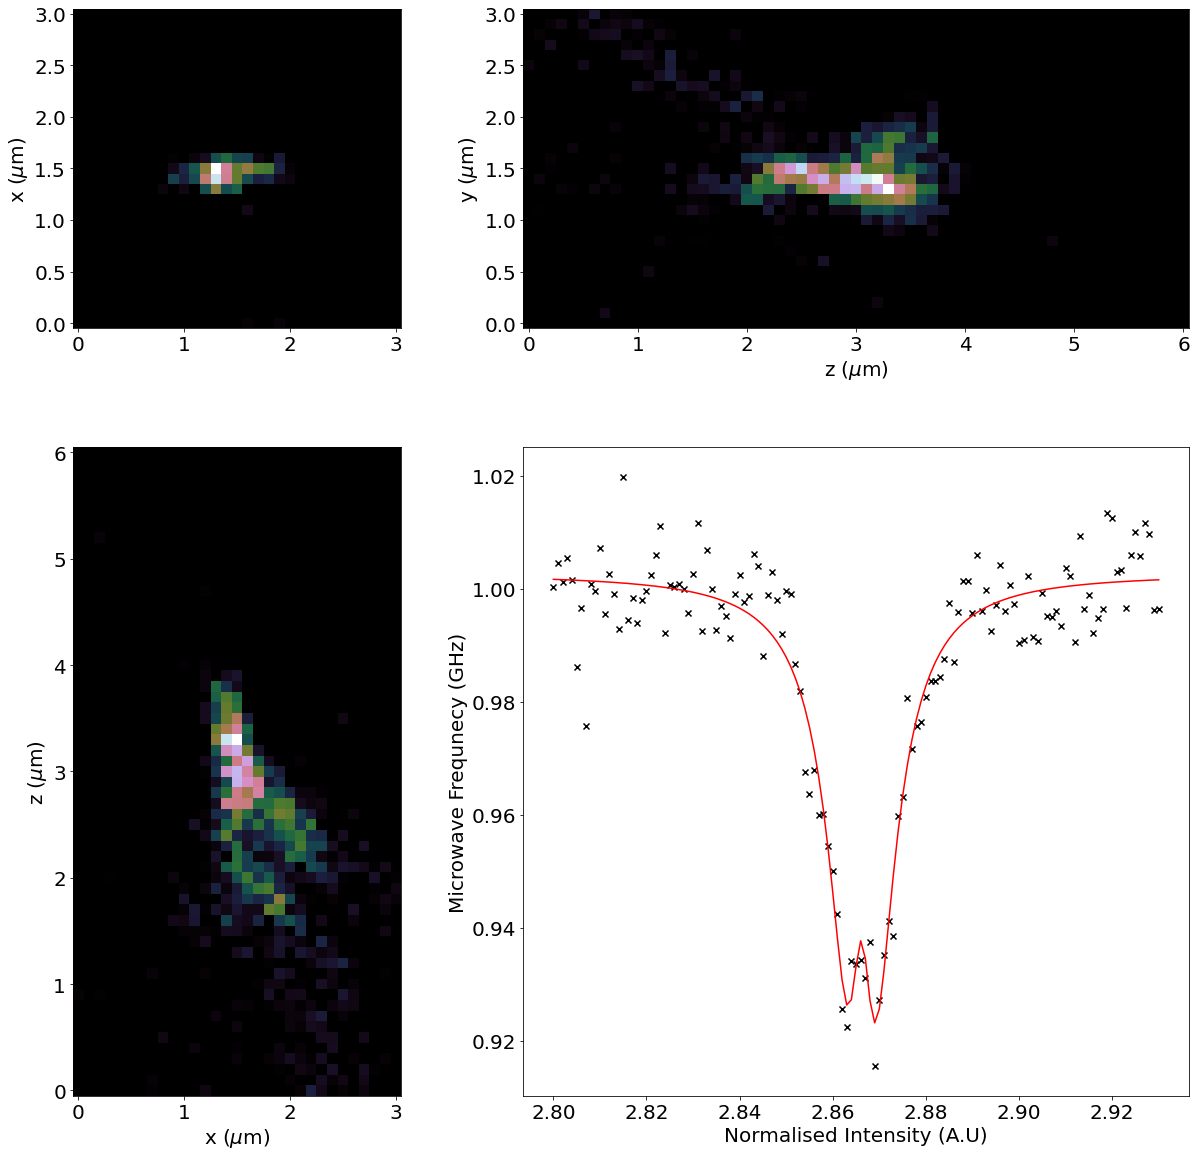

In [83]:
fig = plot.figure()

plot.rcParams.update({'font.size' : 20})
plot.rcParams.update({'figure.figsize' :[20, 20]})

ax1 = plot.subplot2grid((20, 20),(0,0), rowspan = 6, colspan = 6)
ax1.set_ylabel(r'y ($\mu$m)')
ax1.set_ylabel(r'x ($\mu$m)')
ax1 = plot.pcolormesh(scan_range[0], scan_range[1], psf_data[nd_locs[0][0], :, :], vmin=25, 
                         cmap = 'cubehelix')


ax2 = plot.subplot2grid((20, 20),(8,0), rowspan = 12, colspan = 6)
ax2.set_ylabel(r'z ($\mu$m)')
ax2.set_xlabel(r'x ($\mu$m)')
ax2 = plot.pcolormesh(scan_range[1], scan_range[2], psf_data[:, :, nd_locs[0][2]], vmin=25, 
                         cmap = 'cubehelix')


ax3 = plot.subplot2grid((20, 20),(0,8), rowspan = 6, colspan = 12)
ax3.set_ylabel(r'y ($\mu$m)')
ax3.set_xlabel(r'z ($\mu$m)')
ax3 = plot.pcolormesh(scan_range[2], scan_range[1], psf_data[:, nd_locs[0][1], :].transpose(), vmin=25, 
                         cmap = 'cubehelix')

ax4 = plot.subplot2grid((20, 20),(8,8), rowspan = 12, colspan = 12)
ax4.set_ylabel('Microwave Frequnecy (GHz)')
ax4.set_xlabel('Normalised Intensity (A.U)')
ax4 = plot.scatter(freq, mean_norm_odmr, marker = 'x', color = 'k')
plot.plot(freq, y_fit, color = 'r' )


plot.show()